In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

ModuleNotFoundError: ignored

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
import imutils

def show_images(images,figure,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figure)
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)




class Scanner:
    """
    Class used to take captured image and transform it to scanned

    ...

    Attributes
    ----------
    img : np.ndarray
        image to be scanned
    original : np.ndarray
        original copy of the image kept for visualizing
    GAUSSIAN_SIZE : tuple
        Window size of gaussian filter
    CANNY_L_THRESH : int
        Low threshold of canny edge detector
    CANNY_H_THRESH : int
        High threshold of canny edge detector
    DILATION_SIZE : tuple
        Element size of dilation
    DILATION_ITERS : int
        Number of dilations
    EROSION_SIZE : tuple
        Element size of erosion
    EROSION_ITERS : int
        Number of erosions
    
    Methods
    -------
    get_edges()
        return an image wiht edges of original

    get_corners(edged)
        return return the corners of the scanned paper

    order_pts(pts)
        return an ordered version of the corners (top-left,top-right,bottom-right,bottom-left)

    get_dst_pts(rect)
        return the new dimension points for the scanned image
    
    trnasform(visualize=True)
        return the transfomed scanned paper
    """

    def __init__(self,img,GAUSSIAN_SIZE=(9,9),CANNY_L_THRESH=75,CANNY_H_THRESH=170,DILATION_SIZE=(5,5),DILATION_ITERS=5,EROSION_SIZE=(5,5),EROSION_ITERS=1):
        self.img = img.copy()
        self.original = img.copy()
        self.GAUSSIAN_SIZE = GAUSSIAN_SIZE
        self.CANNY_L_THRESH = EROSION_ITERS
        self.CANNY_H_THRESH = CANNY_H_THRESH
        self.DILATION_SIZE = DILATION_SIZE
        self.DILATION_ITERS = DILATION_ITERS
        self.EROSION_SIZE = EROSION_SIZE
        self.EROSION_ITERS = EROSION_ITERS

    def get_edges(self):
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, self.GAUSSIAN_SIZE, 0)
        edged = cv2.Canny(gray, self.CANNY_L_THRESH, self.CANNY_H_THRESH)
        edged = cv2.dilate(edged,self.DILATION_SIZE,iterations=self.DILATION_ITERS)
        edged = cv2.erode(edged,self.EROSION_SIZE,iterations=self.EROSION_ITERS)

        return edged

    def get_corners(self,edged):
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

        for c in cnts:

            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)

            if len(approx) >= 4:
                corners = approx
                break
        
        return corners

    def order_pts(self,pts):
        rect_pts = np.zeros((4, 2), dtype = "float32")
        s = pts.sum(axis = 1)
        rect_pts[0] = pts[np.argmin(s)]
        rect_pts[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis = 1)
        rect_pts[1] = pts[np.argmin(diff)]
        rect_pts[3] = pts[np.argmax(diff)]
        
        return rect_pts

    def get_dst_pts(self,rect):
        (tl, tr, br, bl) = rect

        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")

        return dst
    
    def trnasform(self,visualize=True):
        
        edged = self.get_edges()
        corners = self.get_corners(edged)
        ordered_corners = self.order_pts(corners.reshape(-1,2))
        transformed_corners = self.get_dst_pts(ordered_corners)
        H = cv2.getPerspectiveTransform(ordered_corners, transformed_corners)
        transformed = cv2.warpPerspective(self.original, H, (int(transformed_corners[2][0]+1), int(transformed_corners[2][1]+1)))

        if visualize:
            plt.figure(0)
            plt.imshow(self.original)
            plt.figure(1)
            plt.imshow(edged)
            cv2.drawContours(self.img, [corners], -1, (0, 255, 0), 15)
            plt.figure(2)
            plt.imshow(self.img)
            plt.figure(3)
            plt.imshow(transformed)
        return transformed




In [ ]:
def removeShadow(img):
  rgb_planes = cv2.split(img)

  result_planes = []
  result_norm_planes = []
  for plane in rgb_planes:
      dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
      bg_img = cv2.medianBlur(dilated_img, 21)
      diff_img = 255 - cv2.absdiff(plane, bg_img)
      norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
      result_planes.append(diff_img)
      result_norm_planes.append(norm_img)

  result = cv2.merge(result_planes)
  result_norm = cv2.merge(result_norm_planes)
  return result

(872, 2145, 3)


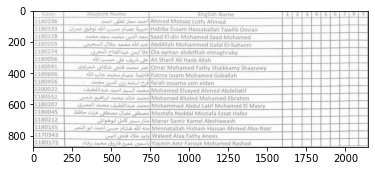

In [ ]:
img = cv2.imread('/content/2.jpg')
img=removeShadow(img)
#convert to grey scale 
sc = Scanner(img)
scanned = sc.trnasform(visualize=False)

cv2.imwrite('/content/scanned.png',scanned)

#thresholding the image to a binary image
# scanned=cv2.cvtColor(scanned, cv2.COLOR_BGR2GRAY)
# img_bin = (scanned <= 115).astype(float)
plt.figure(4)
plt.imshow(scanned)
print(scanned.shape)

##Reading the image 

(872, 2145)
(872, 2145)


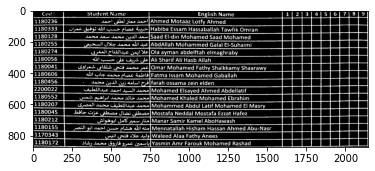

In [ ]:
# #read your file
# file=r'/content/scanned.png'
# img = cv2.imread(file,0)
# print(img.shape)
# #thresholding the image to a binary image
scanned = cv2.cvtColor(scanned, cv2.COLOR_BGR2GRAY)
print(scanned.shape)
thresh,img_bin = cv2.threshold(scanned,115,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('/content/cv_inverted.png',img_bin)
#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

##Define kernels

In [ ]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

##Vertical lines

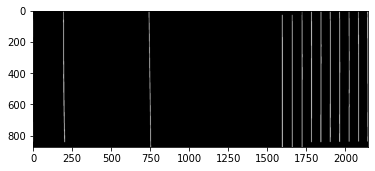

In [ ]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("/content/vertical.jpg",vertical_lines)
#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

##Horizontal lines

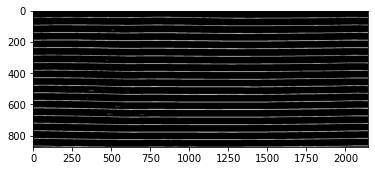

In [ ]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("/content/horizontal.jpg",horizontal_lines)
#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

##Combine vertical with horizontal

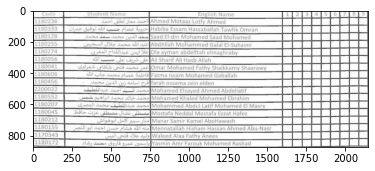

In [ ]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("/content/img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

##Detect contours 

In [ ]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
def sort_contours(cnts, method="left-to-right"):
  # initialize the reverse flag and sort index
  reverse = False
  i = 0
  # handle if we need to sort in reverse
  if method == "right-to-left" or method == "bottom-to-top":
    reverse = True
  # handle if we are sorting against the y-coordinate rather than
  # the x-coordinate of the bounding box
  if method == "top-to-bottom" or method == "bottom-to-top":
    i = 1
  # construct the list of bounding boxes and sort them from top to
  # bottom
  boundingBoxes = [cv2.boundingRect(c) for c in cnts]
  (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
  key=lambda b:b[1][i], reverse=reverse))
  # return the list of sorted contours and bounding boxes
  return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")
print(contours[10])

[[[1803    5]]

 [[1802    6]]

 [[1787    6]]

 [[1787   40]]

 [[1788   41]]

 [[1788   47]]

 [[1841   47]]

 [[1841    5]]]


## Retrieve the cells position

In [ ]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

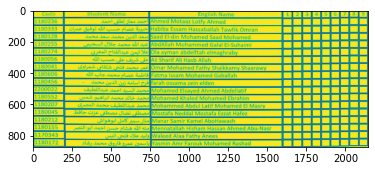

216


In [ ]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and (h<500 and h>10)):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image)
plt.show()
#872, 2145
print(len(box))

In [ ]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(len(column))
print(len(row))

12
18


In [ ]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [ ]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [ ]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)
print(len(finalboxes[17]))

for hhh in finalboxes:
  print(hhh[0])
# print(len(finalboxes[0]))
#0
#50
#100

12
[[4, 0, 190, 48]]
[[5, 50, 188, 45]]
[[5, 98, 189, 45]]
[[5, 147, 189, 43]]
[[4, 195, 190, 43]]
[[4, 243, 190, 43]]
[[4, 290, 190, 44]]
[[4, 339, 190, 43]]
[[4, 387, 190, 43]]
[[3, 435, 192, 43]]
[[3, 483, 192, 43]]
[[3, 531, 193, 44]]
[[3, 579, 193, 44]]
[[3, 627, 194, 45]]
[[3, 675, 195, 46]]
[[4, 724, 195, 45]]
[[5, 772, 195, 46]]
[[5, 820, 196, 47]]


In [ ]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                x,y,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = scanned[ y:y+h,x:x +w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)
                
                out = pytesseract.image_to_string(erosion) if  not(j==1) else ""
                out=out.replace("\n","").replace("|","").replace("_","").replace("[","").strip()
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3') if  not(j==1) else ""
                    out=out.replace("\n","").replace("|","").replace("_","").replace("[","").strip()

                inner = inner +" "+ out
            outer.append(inner)

#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
dataframe.reset_index(drop=True, inplace=True)
data = dataframe.style.set_properties(align="left")
data.to_excel("/content/output.xlsx", index=False)

12


In [ ]:
# dataframe = dataframe.applymap(lambda x: x.encode('unicode_escape').
#                  decode('utf-8') if isinstance(x, str) else x)
# dataframe.reset_index(drop=True, inplace=True)
# print(dataframe)
# data = dataframe.style.set_properties(align="left")
# data.to_excel("/content/output.xlsx", index=False)


          0  1                                          2  3  4   ... 7  8  9  10 11
0                                             English Name        ...               
1                                 Ahmed Motaaz Lotfy Ahmed        ...               
2                    Habiba Essam Hassaballah Tawfik Omran        ...               
3                         Saad El-din Mohamed Saad Mohamed        ...               
4                       AbdAllah Mohammed Galal El-Suhaimi        ...               
5                                                                 ...               
6    1180056                                                      ...               
7    1180041         Omar Mohamed Fathy Shalkkamy Shaarawy        ...               
8                             Fatma Issam Mohamed Gaballah        ...               
9                                  farah ossama zein elden        ...               
10                        Mohamed Elsayed Ahmed Abdellatif       

In [ ]:
# print(dataframe.iloc[8])
#Converting it in a excel-file
# data.to_csv("/content/output.csv", index=False)



0                           1180606
1                                  
2      Fatma Issam Mohamed Gaballah
3                                  
4                                  
5                                  
6                                  
7                                  
8                                  
9                                  
10                                 
11                                 
Name: 8, dtype: object


ValueError: ignored

In [ ]:
! pip install pytesseract 
! pip install tesseract 
! sudo apt-get update
! sudo apt-get install libleptonica-dev 
! sudo apt-get install tesseract-ocr tesseract-ocr-dev
! sudo apt-get install libtesseract-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graph

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'

In [ ]:
!sudo apt install tesseract-ocr
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [ ]:

class CellDetector:
    """
    Class used to take the scanned image and detect the cells of a table

    ...

    Attributes
    ----------
    img : np.ndarray
        scanned image (expected an rgb image)
    
    Methods
    -------
    get_table_cells()
        returns an array of rows where each row has cols and each col consists of [x,y,w,h] 
        where [x,y,w,h] are the bounding boxes of the cells

        len(returnedArray) => number of rows
        len(returnedArray[0]) => number of cols 

    """

    def __init__(self,img,visualize=False):
      self.visualize=visualize
      gray_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      thresh,img_bin = cv2.threshold(gray_img,115,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
      #inverting the image 
      img_bin = 255-img_bin
      self.img = img_bin
      # Length(width) of kernel as 100th of total width
      kernel_len = np.array(img).shape[1]//100
      # Defining a vertical kernel to detect all vertical lines of image 
      self.ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
      # Defining a horizontal kernel to detect all horizontal lines of image
      self.hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
      # A kernel of 2x2
      self.kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    def _sort_contours(self,cnts, method="left-to-right"):
      # initialize the reverse flag and sort index
      reverse = False
      i = 0
      # handle if we need to sort in reverse
      if method == "right-to-left" or method == "bottom-to-top":
          reverse = True
      # handle if we are sorting against the y-coordinate rather than
      # the x-coordinate of the bounding box
      if method == "top-to-bottom" or method == "bottom-to-top":
          i = 1
      # construct the list of bounding boxes and sort them from top to
      # bottom
      boundingBoxes = [cv2.boundingRect(c) for c in cnts]
      (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
      key=lambda b:b[1][i], reverse=reverse))
      # return the list of sorted contours and bounding boxes
      return (cnts, boundingBoxes)


    def get_table_cells(self):
      #Use vertical kernel to detect and save the vertical lines in a jpg
      image_1 = cv2.erode(self.img, self.ver_kernel, iterations=3)
      vertical_lines = cv2.dilate(image_1, self.ver_kernel, iterations=3)

      #Use horizontal kernel to detect and save the horizontal lines in a jpg
      image_2 = cv2.erode(self.img, self.hor_kernel, iterations=3)
      horizontal_lines = cv2.dilate(image_2, self.hor_kernel, iterations=3)

      # Combine horizontal and vertical lines in a new third image, with both having same weight.
      img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

      #Eroding and thesholding the image
      img_vh = cv2.erode(~img_vh, kernel, iterations=2)
      thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
      
      bitxor = cv2.bitwise_xor(self.img,img_vh)
      bitnot = cv2.bitwise_not(bitxor)

      if self.visualize:
        #Plotting the generated image
        plotting = plt.imshow(img_vh,cmap='gray')
        plt.show()

      # Detect contours for following box detection
      contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      # Sort all the contours by top to bottom.
      contours, boundingBoxes = self._sort_contours(contours, method="top-to-bottom")
      #Create list box to store all boxes in  
      box = []
      # Get position (x,y), width and height for every contour and show the contour on image
      for c in contours:
          x, y, w, h = cv2.boundingRect(c)
          if (w<1000 and (h<500 and h>10)):
              image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
              box.append([x,y,w,h])

      #Creating two lists to define row and column in which cell is located
      row=[]
      column=[]
      j=0

      #Sorting the boxes to their respective row and column
      for i in range(len(box)):    
              
          if(i==0):
              column.append(box[i])
              previous=box[i]    
          
          else:
              if(box[i][1]<=previous[1]+mean/2):
                  column.append(box[i])
                  previous=box[i]            
                  
                  if(i==len(box)-1):
                      row.append(column)        
                  
              else:
                  row.append(column)
                  column=[]
                  previous = box[i]
                  column.append(box[i])
                  
      print(column)
      print(row)

      #calculating maximum number of cells
      countcol = 0
      for i in range(len(row)):
          countcol = len(row[i])
          if countcol > countcol:
              countcol = countcol

      #Retrieving the center of each column
      center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

      center=np.array(center)
      center.sort()
      print(center)
      #Regarding the distance to the columns center, the boxes are arranged in respective order

      finalboxes = []
      for i in range(len(row)):
          lis=[]
          for k in range(countcol):
              lis.append([])
          for j in range(len(row[i])):
              diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
              minimum = min(diff)
              indexing = list(diff).index(minimum)
              lis[indexing].append(row[i][j])
          finalboxes.append(lis)
      return finalboxes, bitnot # return the cells and an enhanced image

In [ ]:
cellDetector=CellDetector(scanned)
cells,cells_image=cellDetector.get_table_cells()

[[5, 818, 196, 49], [2089, 819, 53, 44], [2028, 819, 55, 44], [1968, 820, 54, 45], [1907, 821, 54, 45], [1848, 822, 53, 45], [207, 822, 545, 49], [1787, 823, 54, 44], [1727, 823, 54, 45], [1664, 824, 57, 45], [1601, 825, 57, 44], [757, 825, 837, 46]]
[[[2087, 0, 54, 46], [2027, 0, 55, 45], [747, 0, 847, 51], [199, 0, 542, 47], [4, 0, 190, 48], [1967, 1, 55, 45], [1907, 2, 55, 45], [1848, 3, 53, 45], [1787, 3, 55, 45], [1726, 4, 55, 45], [1663, 4, 58, 45], [1600, 4, 58, 46]], [[747, 47, 847, 52], [2028, 48, 54, 45], [1968, 48, 54, 46], [200, 48, 542, 47], [5, 48, 188, 47], [2088, 49, 53, 45], [1908, 50, 54, 45], [1848, 51, 54, 45], [1788, 52, 54, 44], [1727, 52, 54, 45], [1664, 52, 57, 45], [1600, 53, 58, 45]], [[200, 96, 542, 48], [5, 96, 189, 47], [2088, 97, 53, 45], [2028, 97, 54, 44], [1968, 97, 54, 45], [748, 97, 846, 51], [1908, 98, 54, 46], [1848, 99, 54, 45], [1788, 99, 54, 46], [1727, 100, 54, 45], [1664, 100, 57, 46], [1600, 101, 58, 46]], [[2028, 145, 54, 44], [200, 145, 543,

In [ ]:
# cells_image= image returned from the CellDetector, finalboxes= cells,output_path=path of the csv file
def output_csv(cells_image,finalboxes,output_path): 
  #from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
  outer=[]
  for i in range(len(finalboxes)):
      for j in range(len(finalboxes[i])):
          inner=''
          if(len(finalboxes[i][j])==0):
              outer.append(' ')
          else:
              for k in range(len(finalboxes[i][j])):
                  x,y,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                  finalimg = cells_image[ y:y+h,x:x +w]
                  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                  border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                  resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                  dilation = cv2.dilate(resizing, kernel,iterations=1)
                  erosion = cv2.erode(dilation, kernel,iterations=2)
                  
                  out = pytesseract.image_to_string(erosion) if  not(j==1) else ""
                  out=out.replace("\n","").replace("|","").replace("_","").replace("[","").strip()
                  if(len(out)==0):
                      out = pytesseract.image_to_string(erosion, config='--psm 3') if  not(j==1) else ""
                      out=out.replace("\n","").replace("|","").replace("_","").replace("[","").strip()

                  inner = inner +" "+ out
              outer.append(inner)

  #Creating a dataframe of the generated OCR list
  arr = np.array(outer)
  dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
  dataframe.reset_index(drop=True, inplace=True)
  data = dataframe.style.set_properties(align="left")
  data.to_excel(output_path, index=False)

In [ ]:
output_csv(cells_image,cells,"/content/output.xlsx")